In [1]:
'''This script is going to create a model to differentiate cases into differnt categories.
Unsupervised learning will be used to create the categories.
The reasoning behind this, is to be able to assign each observation to a category, and then create a custom
regression model for each category to predict the LOS.'''
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, TargetEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from utils import (
    describe_dataframe, df_train_test, graph_results, reg_train_eval
)

(20867, 1)
(20867,)


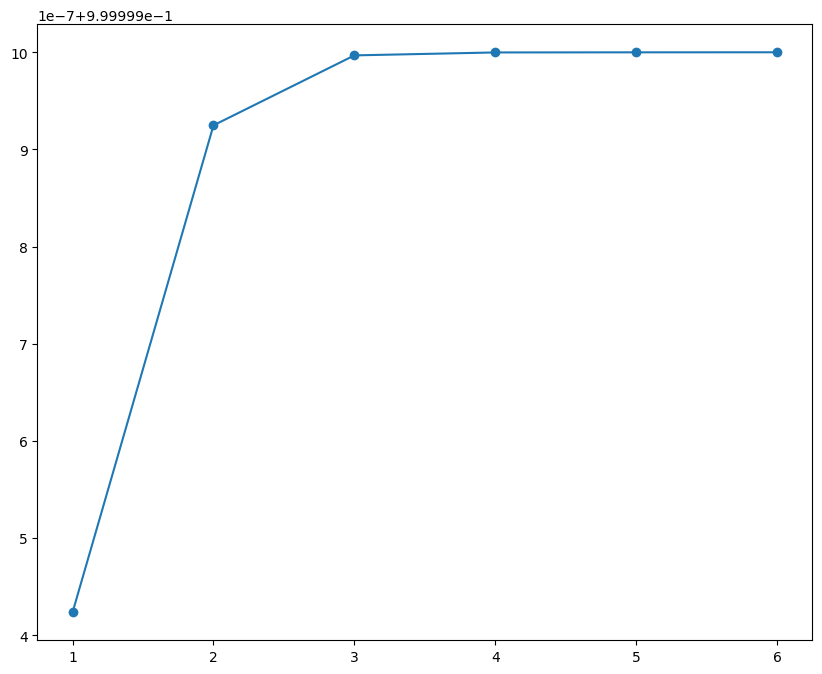

In [2]:
main = pd.read_csv("../data/combo_data.csv")
main

#Identify relevant columns
select_cols = ["LOS" ,
               "YR",  
               "PRNCPAL_DGNS_CD", 
               "CLM_IP_ADMSN_TYPE_CD", 
               "ER_flag", 
               "STATE_CODE", 
               "COUNTY_CD", 
               "BENE_RACE_CD", 
               "ESRD_IND",
               "Age", 
               "TOT_RX_CST_AMT", 
               "NUM_DIAG",
               "SEX_IDENT_CD"]

workingdf_te = main[select_cols].copy()

prncpl_diag_col = pd.DataFrame(data = {"PRNCPL_DGNS_CD": workingdf_te.loc[:,"PRNCPAL_DGNS_CD"]})

print(prncpl_diag_col.shape)

los_col = workingdf_te.loc[:,"LOS"]

print(los_col.shape)

encoder = TargetEncoder(categories='auto', target_type='continuous', smooth='auto', cv=5, random_state=42)

workingdf_te["PRNCPAL_DGNS_CD"] = encoder.fit_transform(prncpl_diag_col, los_col)

workingdf_te = workingdf_te.assign(ESRD_IND = workingdf_te["ESRD_IND"].map({"Y": 1, "0" : 0}))

wdf_rest_te = workingdf_te[workingdf_te["YR"] < 2022]
wdf_2022_te = workingdf_te[workingdf_te["YR"] >= 2022]

ohe = OneHotEncoder(sparse_output=False)

ohe.fit(wdf_rest_te[['CLM_IP_ADMSN_TYPE_CD', 
                  'BENE_RACE_CD', 
                  "SEX_IDENT_CD"]])

ohe_df_rest_te = pd.DataFrame(data = ohe.transform(wdf_rest_te[['CLM_IP_ADMSN_TYPE_CD', 
                                                          'BENE_RACE_CD',
                                                          "SEX_IDENT_CD"]]), 
             columns=ohe.get_feature_names_out(wdf_rest_te[['CLM_IP_ADMSN_TYPE_CD', 
                                                         'BENE_RACE_CD',
                                                         "SEX_IDENT_CD"]].columns))

ohe.fit(wdf_2022_te[['CLM_IP_ADMSN_TYPE_CD', 
                  'BENE_RACE_CD', 
                  "SEX_IDENT_CD"]])
ohe_df_2022_te = pd.DataFrame(data = ohe.transform(wdf_2022_te[['CLM_IP_ADMSN_TYPE_CD', 
                                                          'BENE_RACE_CD',
                                                          "SEX_IDENT_CD"]]), 
             columns=ohe.get_feature_names_out(wdf_2022_te[['CLM_IP_ADMSN_TYPE_CD', 
                                                         'BENE_RACE_CD',
                                                         "SEX_IDENT_CD"]].columns))

#drop year, county code, all one hot encoded vars 
no_state_wdf_rest_te = wdf_rest_te.drop(columns=["YR", 
                                  "COUNTY_CD", 
                                  'CLM_IP_ADMSN_TYPE_CD', 
                                  'STATE_CODE', 
                                  'BENE_RACE_CD',
                                  "SEX_IDENT_CD"])
no_state_wdf_2022_te = wdf_2022_te.drop(columns=["YR", 
                                  "COUNTY_CD", 
                                  'CLM_IP_ADMSN_TYPE_CD', 
                                  'STATE_CODE', 
                                  'BENE_RACE_CD',
                                  "SEX_IDENT_CD"])

X_train_rest_te = no_state_wdf_rest_te.drop(columns=["LOS"])
y_train_rest_te = no_state_wdf_rest_te["LOS"]
X_test_2022_te = no_state_wdf_2022_te.drop(columns=["LOS"])
y_test_2022_te = no_state_wdf_2022_te["LOS"]

#scaler = StandardScaler()
#X_train_rest_te = scaler.fit_transform(X_train_rest_te)
#X_test_rest_te = scaler.transform(X_test_rest_te)
#X_train_2022_te = scaler.fit_transform(X_train_2022_te)
#X_test_2022_te = scaler.transform(X_test_2022_te)

pca = PCA()
pca.fit(X_train_rest_te)
pca.explained_variance_ratio_
plt.figure(figsize = (10,8))
plt.plot(range(1,X_train_rest_te.shape[1]+1), pca.explained_variance_ratio_.cumsum(), marker = 'o')

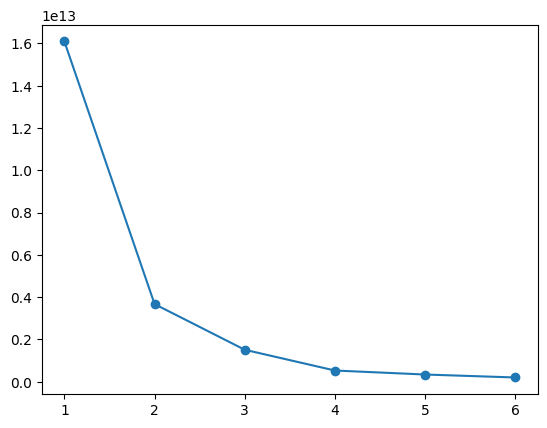

In [3]:
pca = PCA(n_components=3) # It looks like there are 3 main principal components
                            # therefore, we will use these three components to derive 2 kmeans clusters
pca.fit(X_train_rest_te)
scores_pca = pca.transform(X_train_rest_te)
scores_pca_2022 = pca.transform(X_test_2022_te)
wcss = []
for i in range(1,7):
    kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

plt.plot(range(1,7), wcss, marker = 'o')
# Looks like 50 something clusters is the best choice, but that is clinically unreasonable (maybe?)

In [ ]:
# Choosing 2 clusters (based on insights from datasets with and without state)
kmeans_pca = KMeans(n_clusters=2, init='k-means++', random_state=42)

kmeans_pca.fit(scores_pca)
X_train_rest_te['kmeans_cluster'] = kmeans_pca.predict(scores_pca)

X_test_2022_te['kmeans_cluster'] = kmeans_pca.predict(scores_pca_2022)

In [7]:
# Rest of the data (TRAIN SET)
x_train_rest_te_0 = X_train_rest_te[X_train_rest_te["kmeans_cluster"] == 0]
y_train_rest_te_0 = y_train_rest_te[X_train_rest_te[X_train_rest_te["kmeans_cluster"] == 0].index]

x_train_rest_te_1 = X_train_rest_te[X_train_rest_te["kmeans_cluster"] == 1]
y_train_rest_te_1 = y_train_rest_te[X_train_rest_te[X_train_rest_te["kmeans_cluster"] == 1].index]

# 2022 + data (TEST SET)
x_test_2022_te_0 = X_test_2022_te[X_test_2022_te["kmeans_cluster"] == 0]
y_test_2022_te_0 = y_test_2022_te[X_test_2022_te[X_test_2022_te["kmeans_cluster"] == 0].index]

x_test_2022_te_1 = X_test_2022_te[X_test_2022_te["kmeans_cluster"] == 1]
y_test_2022_te_1 = y_test_2022_te[X_test_2022_te[X_test_2022_te["kmeans_cluster"] == 1].index]

In [8]:
# GRID SEARCH GROUP 0

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4, 6],
    'criterion': ['squared_error']  # 'mse' is deprecated, use 'squared_error'
}

# Instantiate model
rf_mod = RandomForestRegressor(random_state=42)

# Define GridSearchCV with multiple scoring metrics
grid_search = GridSearchCV(
    estimator=rf_mod, 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1, 
    scoring='r2' # Grid search will optimize for r_squared
)

grid_search.fit(x_train_rest_te_0, y_train_rest_te_0)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['squared_error'],
                         'max_depth': [3, 5, 10, None],
                         'min_samples_leaf': [2, 4, 6],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='r2')

In [13]:
reg_mod_metrics = {"Train":{},
                   "Test":{}}

predictions = {}

best_params = grid_search.best_params_
best_r_squared = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best R-squared: {best_r_squared}")

best_model = RandomForestRegressor(max_depth=3, 
                                   min_samples_leaf=6,
                                   min_samples_split=2, 
                                   n_estimators=200,
                                   criterion="squared_error",
                                   random_state=42)
reg_train_eval(best_model,
               None,
               x_train_rest_te_0,
               y_train_rest_te_0,
               x_test_2022_te_0,
               y_test_2022_te_0,
               reg_mod_metrics,
               predictions,
               year = "rest_train-2022test-te-std-0")

reg_mod_metrics['Test']

Best Parameters: {'criterion': 'squared_error', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best R-squared: 1.0


{'RandomForestRegressor - NoneType - rest_train-2022test-te-std-0': {'RMSLE': 0.535509417994016,
  'R2': 0.3138726258674408,
  'MAE': 0.9641258845507896,
  'MSE': 6.588329483458234}}

In [10]:
# GRID SEARCH GROUP 1

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4, 6],
    'criterion': ['squared_error']  # 'mse' is deprecated, use 'squared_error'
}

# Instantiate model
rf_mod = RandomForestRegressor(random_state=42)

# Define GridSearchCV with multiple scoring metrics
grid_search = GridSearchCV(
    estimator=rf_mod, 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1, 
    scoring='r2' # Grid search will optimize for r_squared
)

grid_search.fit(x_train_rest_te_1, y_train_rest_te_1)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['squared_error'],
                         'max_depth': [3, 5, 10, None],
                         'min_samples_leaf': [2, 4, 6],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='r2')

In [14]:
best_params = grid_search.best_params_
best_r_squared = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best R-squared: {best_r_squared}")

best_model = RandomForestRegressor(max_depth=5, 
                                   min_samples_split= 2,
                                   min_samples_leaf=2, 
                                   n_estimators=300,
                                   criterion="squared_error",
                                   random_state=42)
reg_train_eval(best_model,
               None,
               x_train_rest_te_1,
               y_train_rest_te_1,
               x_test_2022_te_1,
               y_test_2022_te_1,
               reg_mod_metrics,
               predictions,
               year = "rest_train-2022test-te-std-1")

reg_mod_metrics['Test']

Best Parameters: {'criterion': 'squared_error', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best R-squared: 1.0


{'RandomForestRegressor - NoneType - rest_train-2022test-te-std-0': {'RMSLE': 0.535509417994016,
  'R2': 0.3138726258674408,
  'MAE': 0.9641258845507896,
  'MSE': 6.588329483458234},
 'RandomForestRegressor - NoneType - rest_train-2022test-te-std-1': {'RMSLE': 0.0,
  'R2': 1.0,
  'MAE': 0.0,
  'MSE': 0.0}}

In [4]:
# Choosing 3 clusters (based on insights from datasets with and without state)
kmeans_pca = KMeans(n_clusters=3, init='k-means++', random_state=42)

kmeans_pca.fit(scores_pca)
X_train_rest_te['kmeans_cluster'] = kmeans_pca.predict(scores_pca)

X_test_2022_te['kmeans_cluster'] = kmeans_pca.predict(scores_pca_2022)

In [5]:
# Rest of the data (TRAIN SET)
x_train_rest_te_0 = X_train_rest_te[X_train_rest_te["kmeans_cluster"] == 0]
y_train_rest_te_0 = y_train_rest_te[X_train_rest_te[X_train_rest_te["kmeans_cluster"] == 0].index]

x_train_rest_te_1 = X_train_rest_te[X_train_rest_te["kmeans_cluster"] == 1]
y_train_rest_te_1 = y_train_rest_te[X_train_rest_te[X_train_rest_te["kmeans_cluster"] == 1].index]

x_train_rest_te_2 = X_train_rest_te[X_train_rest_te["kmeans_cluster"] == 2]
y_train_rest_te_2 = y_train_rest_te[X_train_rest_te[X_train_rest_te["kmeans_cluster"] == 2].index]

# 2022 + data (TEST SET)
x_test_2022_te_0 = X_test_2022_te[X_test_2022_te["kmeans_cluster"] == 0]
y_test_2022_te_0 = y_test_2022_te[X_test_2022_te[X_test_2022_te["kmeans_cluster"] == 0].index]

x_test_2022_te_1 = X_test_2022_te[X_test_2022_te["kmeans_cluster"] == 1]
y_test_2022_te_1 = y_test_2022_te[X_test_2022_te[X_test_2022_te["kmeans_cluster"] == 1].index]

x_test_2022_te_2 = X_test_2022_te[X_test_2022_te["kmeans_cluster"] == 2]
y_test_2022_te_2 = y_test_2022_te[X_test_2022_te[X_test_2022_te["kmeans_cluster"] == 2].index]

## Group 0

In [9]:
# GRID SEARCH GROUP 0 !!!

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4, 6],
    'criterion': ['squared_error']  # 'mse' is deprecated, use 'squared_error'
}

# Instantiate model
rf_mod = RandomForestRegressor(random_state=42)

# Define GridSearchCV with multiple scoring metrics
grid_search = GridSearchCV(
    estimator=rf_mod, 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1, 
    scoring='r2' # Grid search will optimize for r_squared
)

grid_search.fit(x_train_rest_te_0, y_train_rest_te_0)

reg_mod_metrics = {"Train":{},
                   "Test":{}}

predictions = {}

best_params = grid_search.best_params_
best_r_squared = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best R-squared: {best_r_squared}")

best_model = RandomForestRegressor(max_depth=3, 
                                   min_samples_leaf=6,
                                   min_samples_split=2, 
                                   n_estimators=200,
                                   criterion="squared_error",
                                   random_state=42)
reg_train_eval(best_model,
               None,
               x_train_rest_te_0,
               y_train_rest_te_0,
               x_test_2022_te_0,
               y_test_2022_te_0,
               reg_mod_metrics,
               predictions,
               year = "rest_train-2022test-te-std-0")

reg_mod_metrics['Test']

Best Parameters: {'criterion': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best R-squared: 0.34602369105418285


{'RandomForestRegressor - NoneType - rest_train-2022test-te-std-0': {'RMSLE': 0.548542376896561,
  'R2': 0.3081739333188751,
  'MAE': 1.0086334594069897,
  'MSE': 6.90295555465202}}

## Group 1

In [10]:
# GRID SEARCH GROUP 1

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4, 6],
    'criterion': ['squared_error']  # 'mse' is deprecated, use 'squared_error'
}

# Instantiate model
rf_mod = RandomForestRegressor(random_state=42)

# Define GridSearchCV with multiple scoring metrics
grid_search = GridSearchCV(
    estimator=rf_mod, 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1, 
    scoring='r2' # Grid search will optimize for r_squared
)

grid_search.fit(x_train_rest_te_1, y_train_rest_te_1)

best_params = grid_search.best_params_
best_r_squared = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best R-squared: {best_r_squared}")

best_model = RandomForestRegressor(max_depth=5, 
                                   min_samples_split= 2,
                                   min_samples_leaf=2, 
                                   n_estimators=300,
                                   criterion="squared_error",
                                   random_state=42)
reg_train_eval(best_model,
               None,
               x_train_rest_te_1,
               y_train_rest_te_1,
               x_test_2022_te_1,
               y_test_2022_te_1,
               reg_mod_metrics,
               predictions,
               year = "rest_train-2022test-te-std-1")

reg_mod_metrics['Test']

Best Parameters: {'criterion': 'squared_error', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best R-squared: 1.0


{'RandomForestRegressor - NoneType - rest_train-2022test-te-std-0': {'RMSLE': 0.548542376896561,
  'R2': 0.3081739333188751,
  'MAE': 1.0086334594069897,
  'MSE': 6.90295555465202},
 'RandomForestRegressor - NoneType - rest_train-2022test-te-std-1': {'RMSLE': 0.0,
  'R2': 1.0,
  'MAE': 0.0,
  'MSE': 0.0}}

## Group 2

In [11]:
# GRID SEARCH GROUP 2

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4, 6],
    'criterion': ['squared_error']  # 'mse' is deprecated, use 'squared_error'
}

# Instantiate model
rf_mod = RandomForestRegressor(random_state=42)

# Define GridSearchCV with multiple scoring metrics
grid_search = GridSearchCV(
    estimator=rf_mod, 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1, 
    scoring='r2' # Grid search will optimize for r_squared
)

grid_search.fit(x_train_rest_te_2, y_train_rest_te_2)

best_params = grid_search.best_params_
best_r_squared = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best R-squared: {best_r_squared}")

best_model = RandomForestRegressor(max_depth=5, 
                                   min_samples_split= 2,
                                   min_samples_leaf=2, 
                                   n_estimators=300,
                                   criterion="squared_error",
                                   random_state=42)
reg_train_eval(best_model,
               None,
               x_train_rest_te_2,
               y_train_rest_te_2,
               x_test_2022_te_2,
               y_test_2022_te_2,
               reg_mod_metrics,
               predictions,
               year = "rest_train-2022test-te-std-2")

reg_mod_metrics['Test']

Best Parameters: {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 200}
Best R-squared: -1.571298546343471


{'RandomForestRegressor - NoneType - rest_train-2022test-te-std-0': {'RMSLE': 0.548542376896561,
  'R2': 0.3081739333188751,
  'MAE': 1.0086334594069897,
  'MSE': 6.90295555465202},
 'RandomForestRegressor - NoneType - rest_train-2022test-te-std-1': {'RMSLE': 0.0,
  'R2': 1.0,
  'MAE': 0.0,
  'MSE': 0.0},
 'RandomForestRegressor - NoneType - rest_train-2022test-te-std-2': {'RMSLE': 0.2268585194766679,
  'R2': 0.2951016399706665,
  'MAE': 0.14015089053039473,
  'MSE': 0.7623771469378481}}

Class sizes: 15487 / 449 / 864